# Examine Antarctic profiles (K=7)

Here, we take the output of the "whole domain" classification notebook (2.0) and look for classes within the Antarctic group of profiles. 

We are exploring a larger value for K, which is still consistent with the dropping BIC score

## Initial setup

### Load modules

In [1]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# pandas for just a couple things
import pandas as pd
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# pyxpcm, xarray, dask
import numpy as np
import xarray as xr
import datetime as dt
import random
# import dask
from dask.distributed import Client
import dask
# for 3D plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import seaborn as sns

#import netCDF4

### Start Dask client

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='3GB')
client

/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42843 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:42843/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:42843/status,Workers: 2
Total threads: 4,Total memory: 3.88 GiB
Comm: tcp://127.0.0.1:40657,Workers: 2
Dashboard: http://127.0.0.1:42843/status,Total threads: 4
Started: Just now,Total memory: 3.88 GiB
Comm: tcp://127.0.0.1:34415,Total threads: 2
Dashboard: http://127.0.0.1:36115/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:42215,


### Select subsetting parameters

Check for consistency with the input file

In [3]:
# plotting subset
subset = range(1000,2000,1)

lon_min = -80
lon_max =  80
lat_min = -85
lat_max = -30

# depth range
zmin = 100.0
zmax = 900.0

### Import data

In [4]:
profiles = xr.open_dataset('processed_data/profiles_80W-80E_85-30S_100-900_labeled.nc')
profiles

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 185612)
Coordinates:
  * profile        (profile) int64 0 1 2 3 4 ... 185608 185609 185610 185611
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] ...
  * CLASS          (CLASS) int64 0 1 2 3 4
Data variables:
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    prof_T         (profile, depth) float64 ...
    prof_S         (profile, depth) float64 ...
    label          (profile) int64 ...
    posteriors     (profile, CLASS) float64 ...

### Select Antarctic profiles

Check for consistency with notebook 2.0

In [5]:
profiles_antarctic = profiles.where(profiles.label==int(4)).dropna('profile')
profiles_antarctic

<xarray.Dataset>
Dimensions:        (CLASS: 5, depth: 15, profile: 35709)
Coordinates:
  * profile        (profile) int64 14 15 16 17 ... 185602 185603 185609 185610
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 51.89 64.79 35.28
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.72 -60.98
  * depth          (depth) float64 100.0 120.0 140.0 160.0 ... 640.0 730.0 820.0
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2017-08-2...
  * CLASS          (CLASS) int64 0 1 2 3 4
Data variables:
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.369e+05 7.369e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.017e+07 2.017e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 1.2e+05 ... 8.4e+04 1.4e+04
    prof_T         (profile, depth) float64 -1.228 -0.9877 ... 1.167 1.067
    prof_S         (profile, depth) float64 34.2 34.25 34.33 ... 34.73 34.72
    label          (profile) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    posteriors     (profile, CLASS) float64 1.969e-45 3.878e-168 ... 1.0

## Data visualization and exploration

### Plot temperature profiles

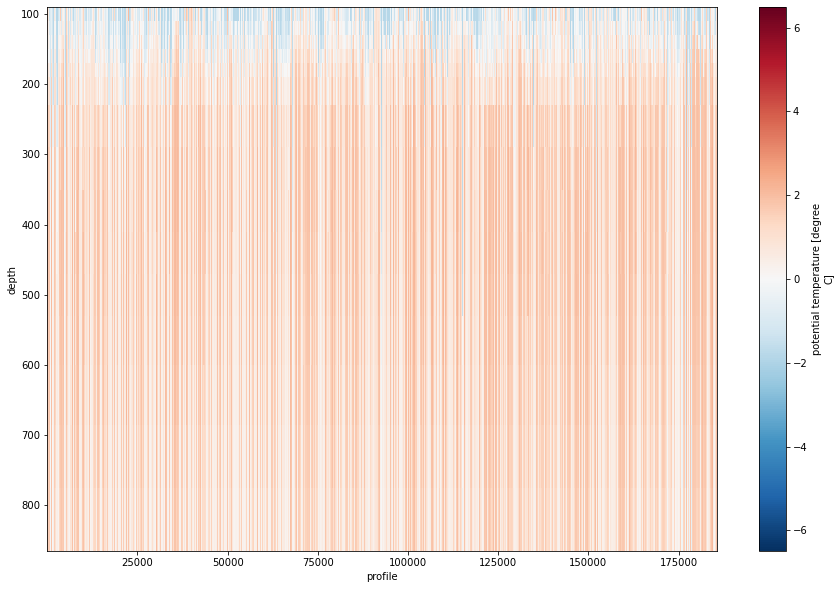

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.prof_T.plot(y='depth', yincrease=False)

### Plot salinity profiles

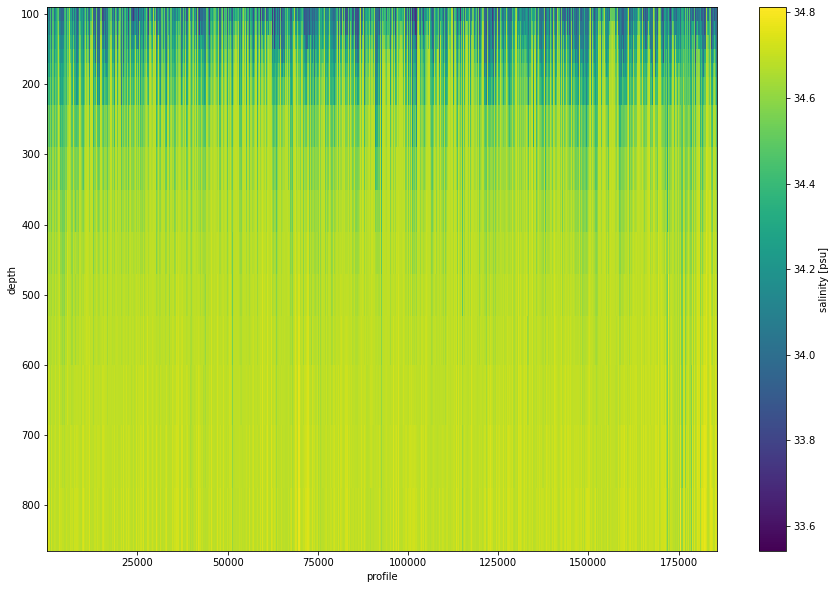

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
profiles_antarctic.prof_S.plot(y='depth', yincrease=False)

### Plot temperature histogram 

(array([3.57350e+04, 4.43950e+04, 1.59234e+05, 1.46523e+05, 1.49330e+05,
        4.02000e+02, 1.00000e+01, 4.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-1.9605945 , -1.11570456, -0.27081462,  0.57407532,  1.41896526,
         2.2638552 ,  3.10874514,  3.95363508,  4.79852502,  5.64341496,
         6.4883049 ]),
 <BarContainer object of 10 artists>)

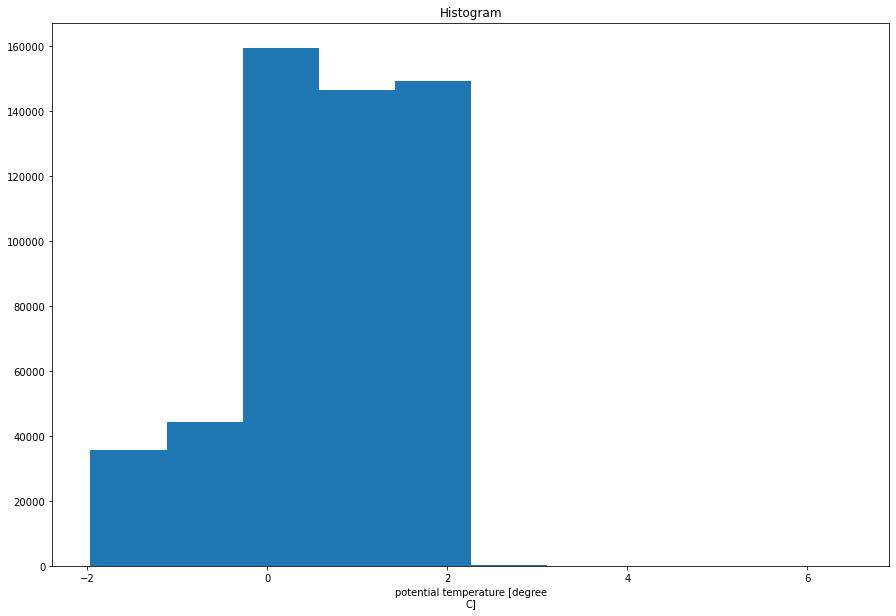

In [8]:
xr.plot.hist(profiles_antarctic.prof_T,figsize=(15,10))

### Plot salinity histogram 

(array([5.70000e+01, 8.04000e+02, 4.81400e+03, 1.67650e+04, 2.29790e+04,
        3.11940e+04, 4.32740e+04, 6.58410e+04, 2.08047e+05, 1.41860e+05]),
 array([33.54245915, 33.66937578, 33.7962924 , 33.92320903, 34.05012566,
        34.17704228, 34.30395891, 34.43087553, 34.55779216, 34.68470879,
        34.81162541]),
 <BarContainer object of 10 artists>)

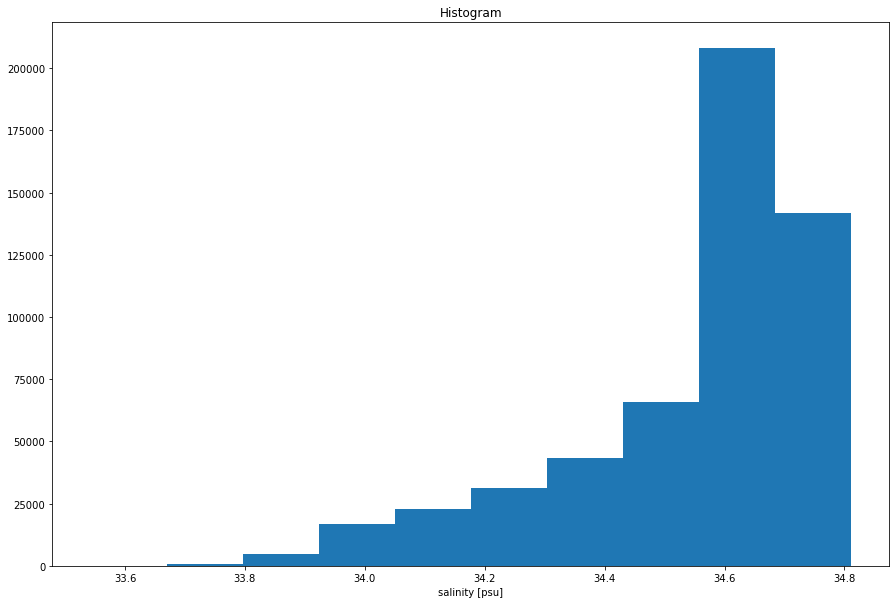

In [9]:
xr.plot.hist(profiles_antarctic.prof_S,figsize=(15,10))

### Apply unsupervised classification method

### Preprocessing, scaling, and dimensionality reduction

In [10]:
# scale salinity
X = profiles_antarctic.prof_S
scaled_S = preprocessing.scale(X)
scaled_S.shape

# scale temperature
X = profiles_antarctic.prof_T
scaled_T = preprocessing.scale(X)
scaled_T.shape

# concatenate 
Xscaled = np.concatenate((scaled_T,scaled_S),axis=1)

# create PCA object
pca = PCA(n_components=8)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# add PCA values to the profiles Dataset
PCA1 = xr.DataArray(Xpca[:,0],dims='profile')
PCA2 = xr.DataArray(Xpca[:,1],dims='profile')
PCA3 = xr.DataArray(Xpca[:,2],dims='profile')

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9848536571248692

### Use BIC and AIC to inform number of classes

In [11]:
# select parameters
max_N = 20     # the maximum number of classes to try 
max_bic_iter = 20  # the maximum number of iterations for BIC
max_aic_iter = max_bic_iter  # the maximum number of iterations for AIC

# initialize, declare variables
bic_scores = np.zeros((2,max_bic_iter))
aic_scores = np.zeros((2,max_aic_iter))

# loop through the maximum number of classes, estimate BIC
n_components_range = range(2, max_N)
bic_iter_range = range(0,max_bic_iter)
aic_iter_range = range(0,max_aic_iter)

# iterate through all the covariance types (just 'full' for now)
cv_types = ['full']

# loop through cv_types, components, and iterations
for cv_type in cv_types:
    # iterate over all the possible numbers of components
    for n_components in n_components_range:
        bic_one = []
        aic_one = []
        # repeat the BIC step for better statistics
        for bic_iter in bic_iter_range:
            # select a new random subset
            rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
            Xpca_for_BIC = Xpca[rows_id,:]
            # fit a Gaussian mixture model
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type,
                                          random_state=42)

            # uncomment for 'rapid' BIC fitting
            gmm.fit(Xpca_for_BIC)

            # append this BIC score to the list
            bic_one.append(gmm.bic(Xpca_for_BIC))
            aic_one.append(gmm.aic(Xpca_for_BIC))
            Xpca_for_BIC = []
            Xpca_for_AIC = []

        # stack the bic scores into a single 2D structure
        bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))
        aic_scores = np.vstack((aic_scores, np.asarray(aic_one)))

# the first two rows are not needed; they were only placeholders
bic_scores = bic_scores[2:,:]
aic_scores = aic_scores[2:,:]

# mean values for BIC and AIC
bic_mean = np.mean(bic_scores, axis=1)
aic_mean = np.mean(aic_scores, axis=1)

# standard deviation for BIC and AIC
bic_std = np.std(bic_scores, axis=1)
aic_std = np.std(aic_scores, axis=1)

Text(0, 0.5, 'BIC score')

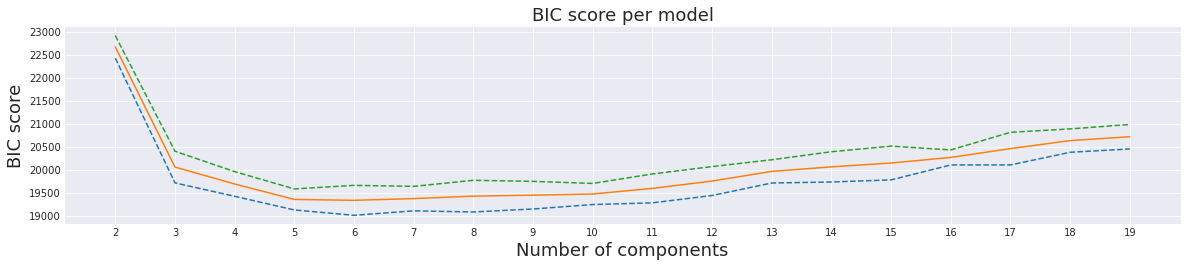

In [12]:
# plot the BIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, bic_mean-bic_std, '--')  
plt.plot(n_components_range, bic_mean, '-')  
plt.plot(n_components_range, bic_mean+bic_std, '--')  
plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('BIC score',fontsize=18)
#plt.show()

Interestingly, there is a minimum between 5-9. We'll opt for the smaller number for ease of interpretation. 

### Plot the AIC scores

Text(0, 0.5, 'AIC score')

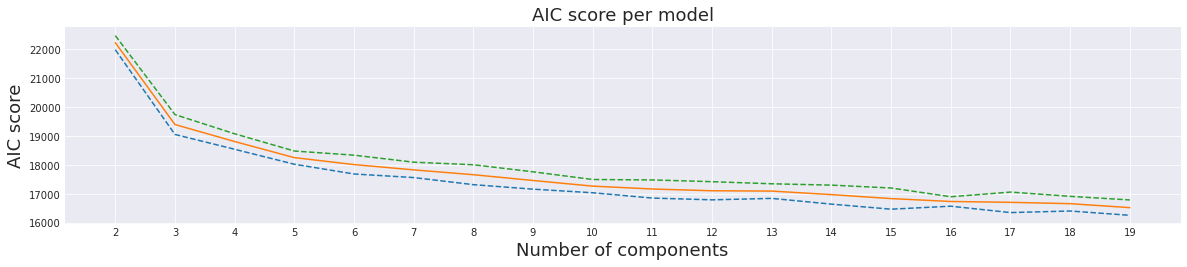

In [13]:
# plot the AIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range, aic_mean-aic_std, '--')  
plt.plot(n_components_range, aic_mean, '-')  
plt.plot(n_components_range, aic_mean+aic_std, '--')  
plt.xticks(n_components_range)
plt.title('AIC score per model', fontsize=18)
spl.set_xlabel('Number of components',fontsize=18)
spl.set_ylabel('AIC score',fontsize=18)
#plt.show()

### Apply selected GMM

In [14]:
# set variables
n_components_selected = 7

# establish gmm
best_gmm = mixture.GaussianMixture(n_components=n_components_selected,
                                   covariance_type='full',
                                   random_state=42)

# fit this GMM
best_gmm.fit(Xpca)

# check to make sure that n_comp is as expected
n_comp = gmm.n_components

# select colormap
colormap = plt.get_cmap('tab10', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
#df.insert(3,'label',labels,True)
#df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
#posterior_probs.shape

# convert labels into xarray format
xlabels = xr.DataArray(labels, coords=[profiles_antarctic.profile], dims='profile')

# convert posterior probabilities into xarray format
gmm_classes = [b for b in range(0,n_components_selected,1)]
xprobs = xr.DataArray(posterior_probs, 
                      coords=[profiles_antarctic.profile, gmm_classes], 
                      dims=['profile', 'CLASS'])

# add label DataArray to Dataset
profiles_antarctic = profiles_antarctic.assign({'label':xlabels})
profiles_antarctic = profiles_antarctic.assign({'posteriors':xprobs})

## Plot GMM results

### Calculate class means

In [15]:
# create grouped object using the labels
grouped = profiles_antarctic.groupby("label")

# class means and standard deviations
class_means = grouped.mean()
class_stds = grouped.std()

# visualize grouped dataset
#class_means

### Plot vertical structure of class means: temperature 

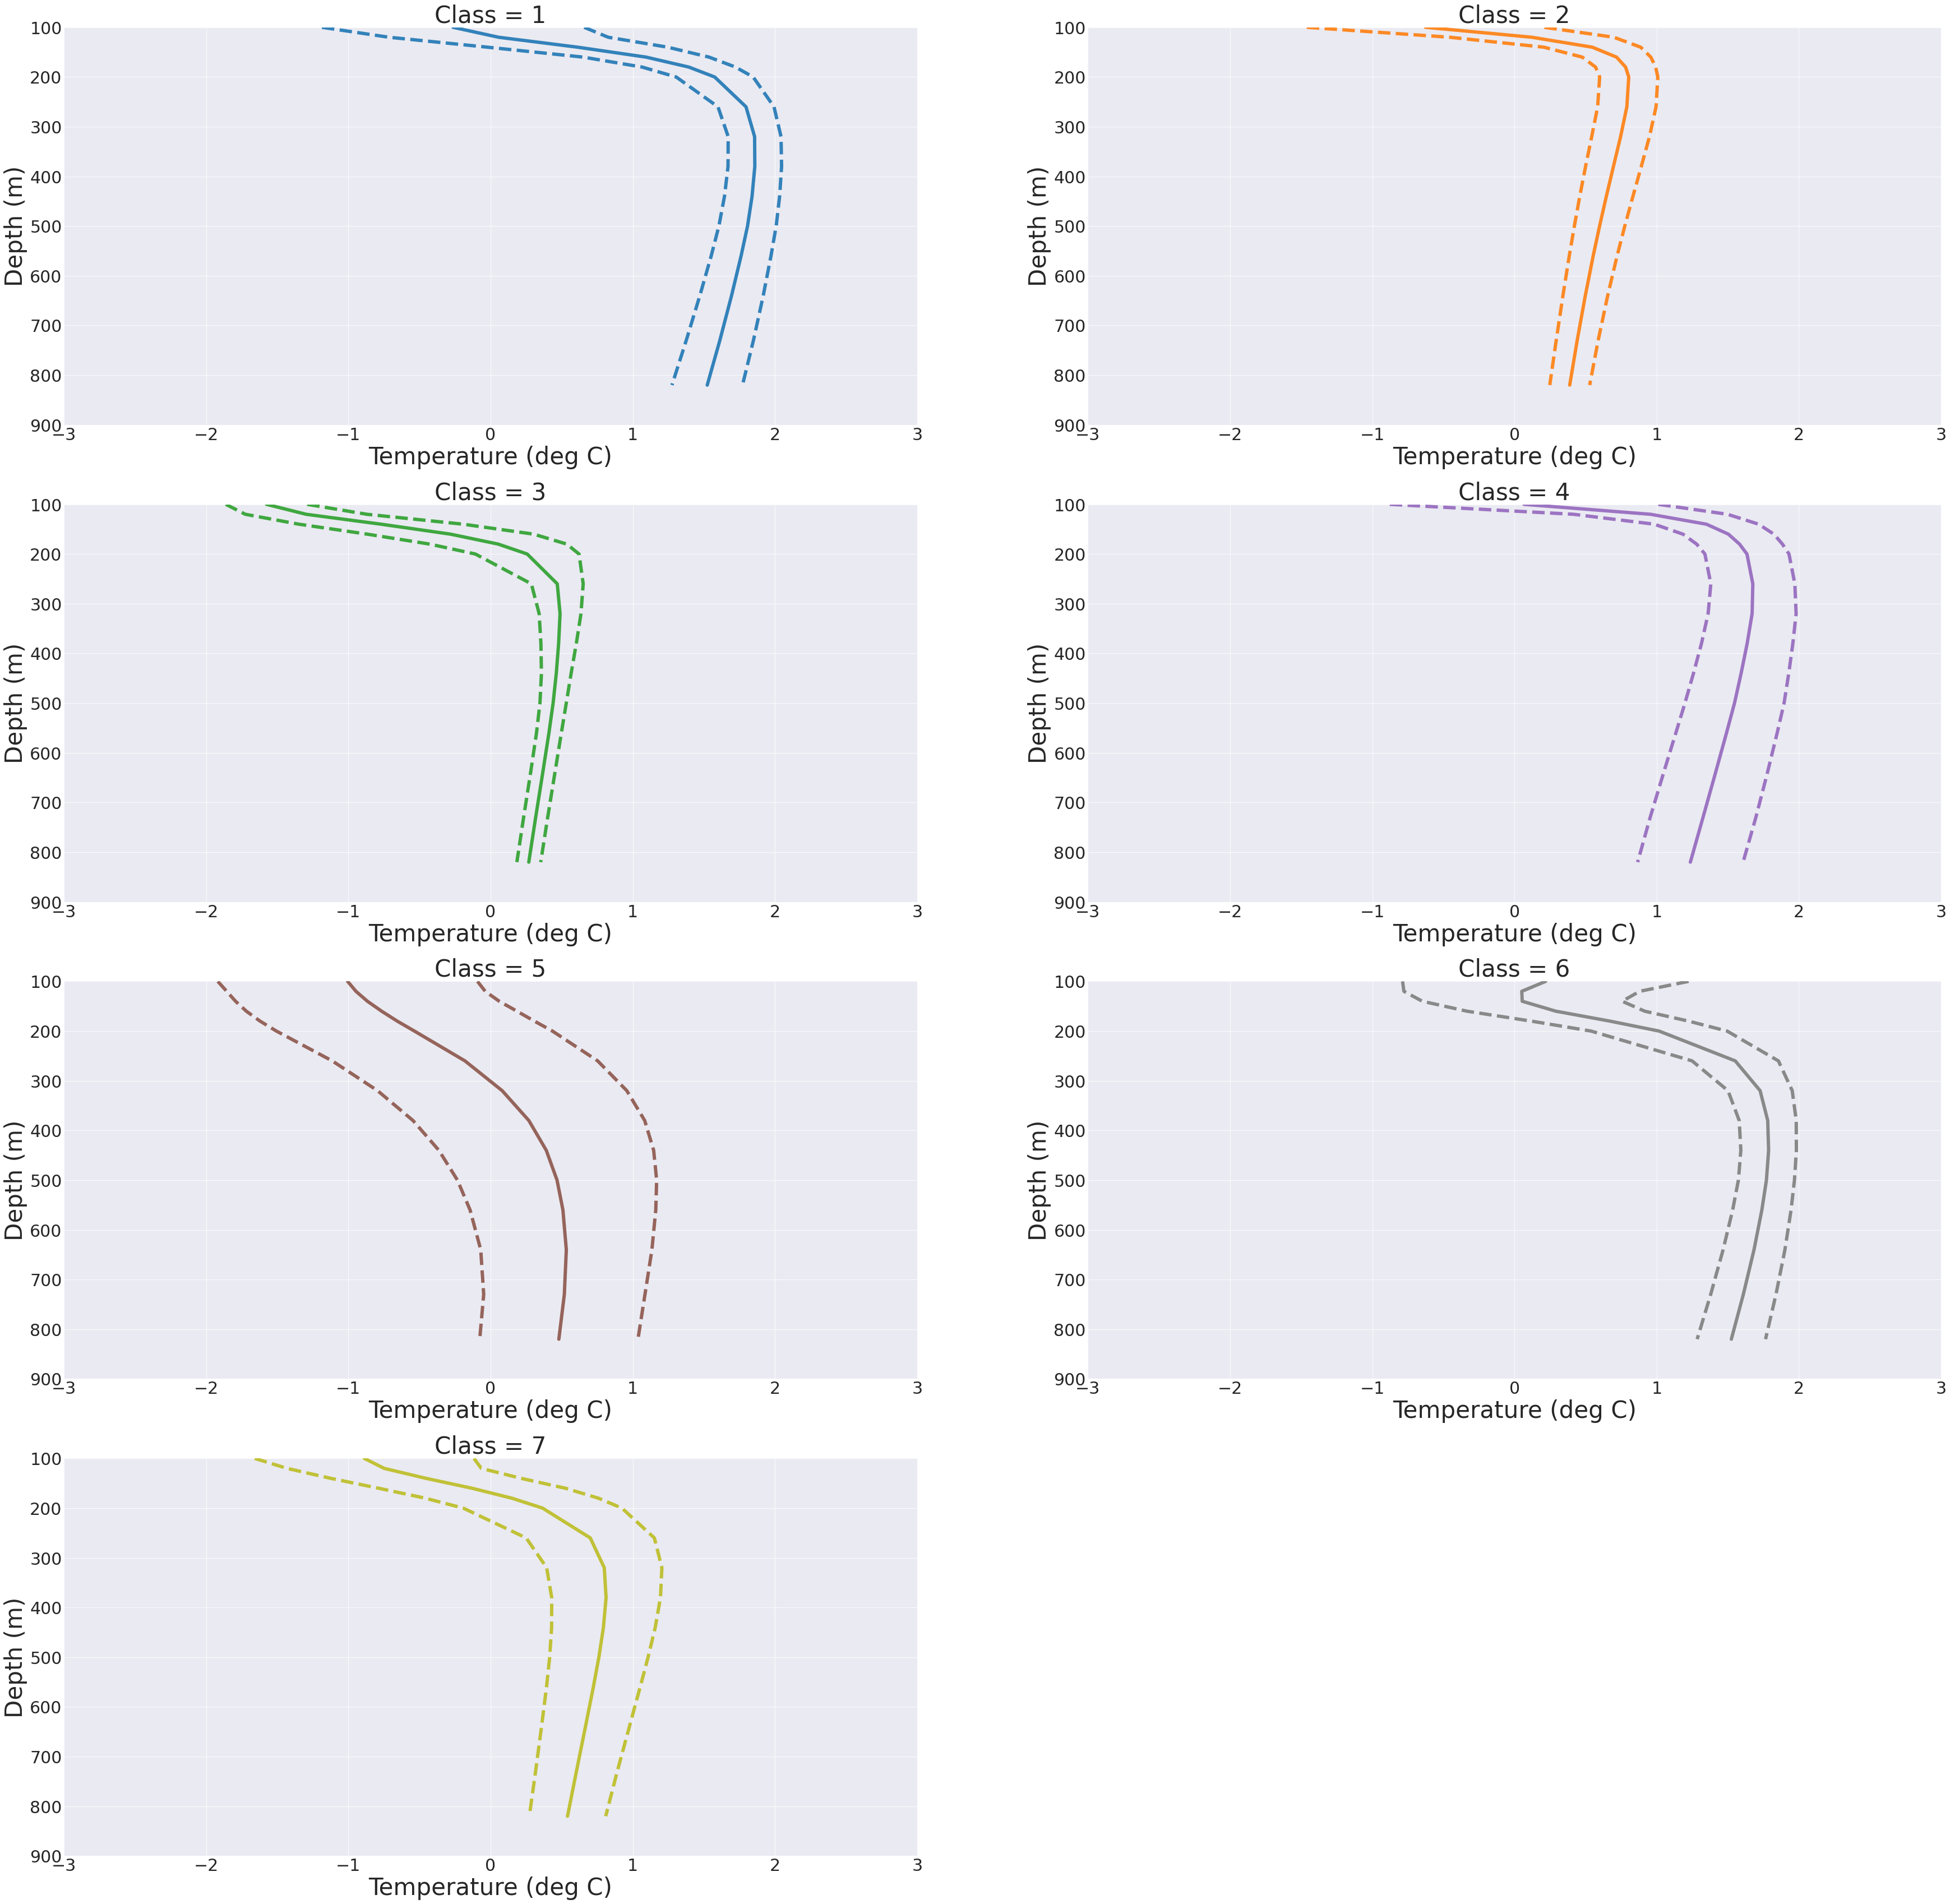

In [16]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_T = class_means.prof_T[nrow,:].values
    
    # extract stdevs
    std_T = class_stds.prof_T[nrow,:].values
    
    # select subplot
    ax = plt.subplot(4,2,num)
    plt.plot(mean_T, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin,zmax])
    plt.xlim([-3, 3])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Temperature (deg C)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

### Plot vertical structure of class means: salinity

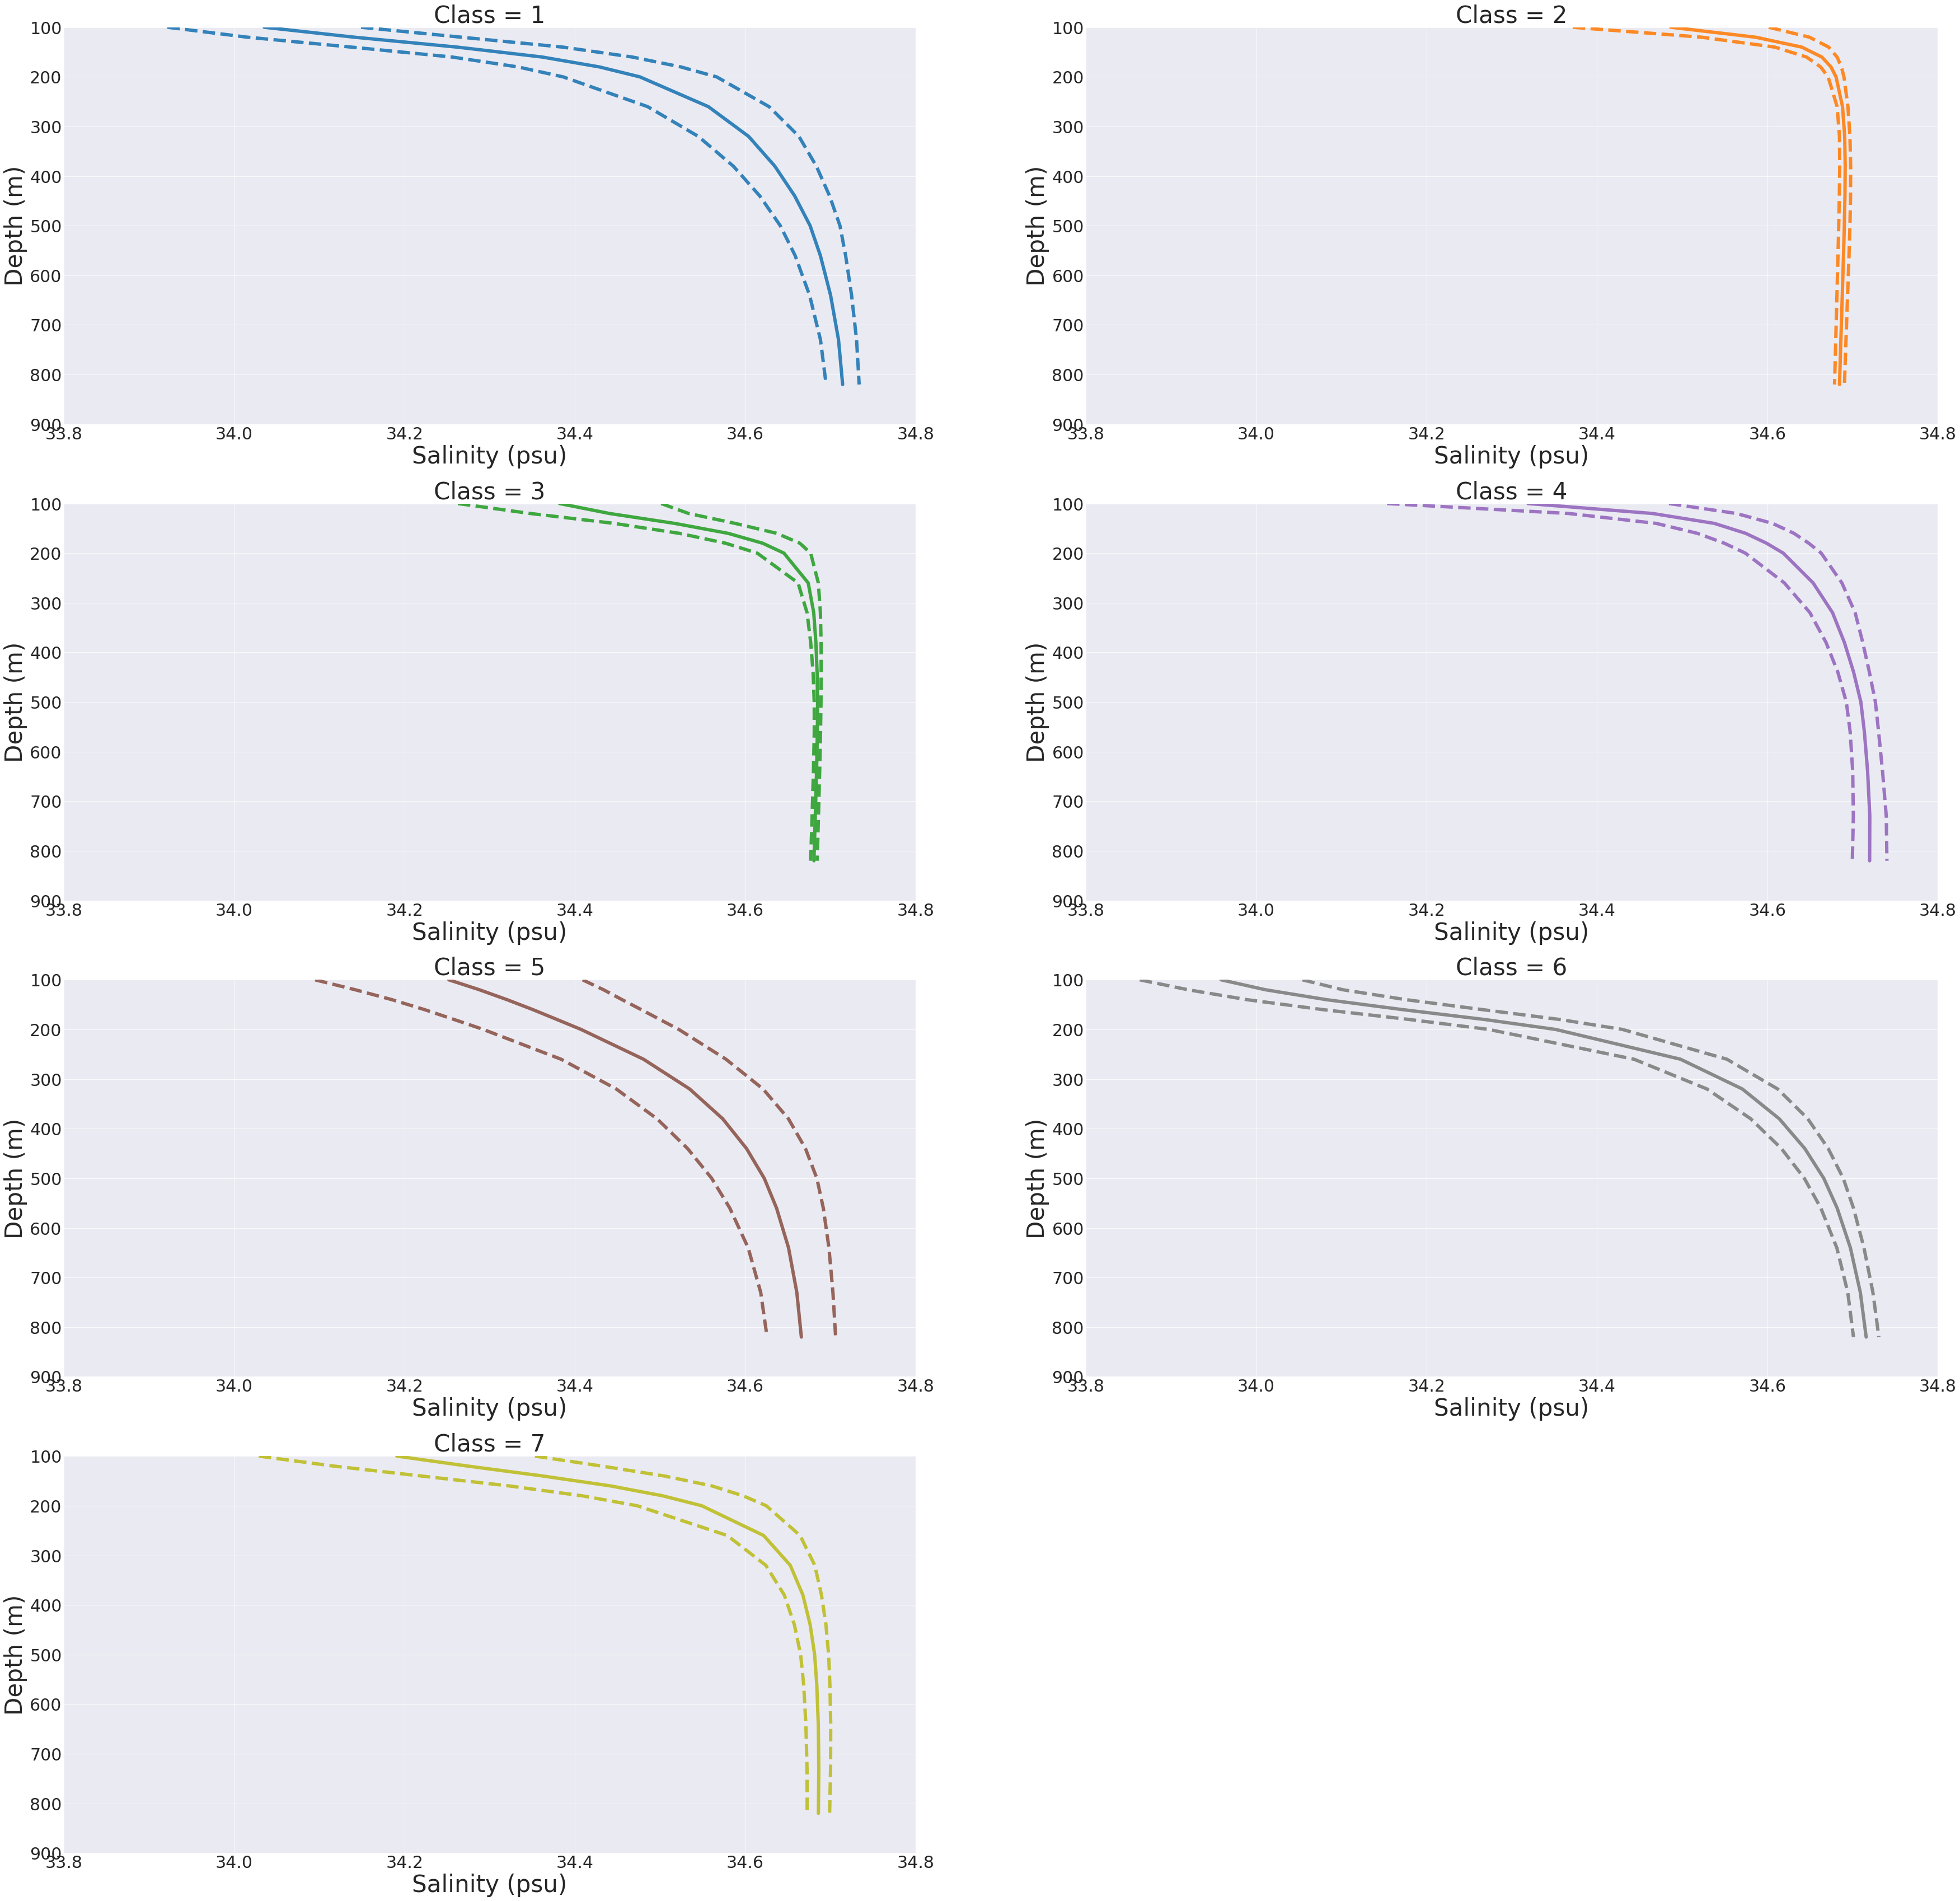

In [17]:
cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# vertical coordinate
z = profiles_antarctic.depth.values    
    
# iterate over groups
num = 0
for nrow in range(0,n_components_selected):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    
    # extract means
    mean_S = class_means.prof_S[nrow,:].values
    
    # extract stdevs
    std_S = class_stds.prof_S[nrow,:].values
    
    # select subplot
    ax = plt.subplot(4,2,num)
    plt.plot(mean_S, z, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S+std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_S-std_S, z, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([zmin, zmax])
    plt.xlim([33.8, 34.8])
    
   #text box
    fs = 42 # font size
    plt.xlabel('Salinity (psu)', fontsize=fs)
    plt.ylabel('Depth (m)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    
    # font and axis stuff
    plt.gca().invert_yaxis()
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
   

### Plot label map

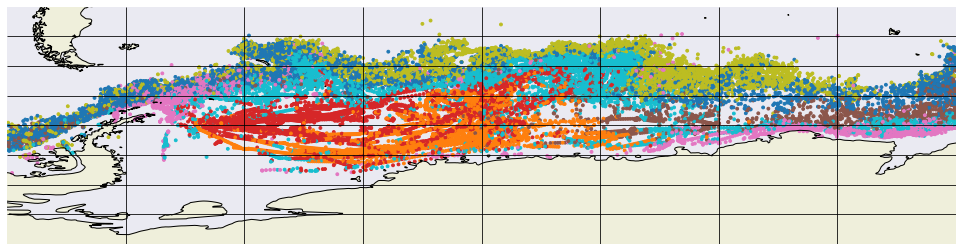

In [18]:
# extract values as new DataArrays
df1D = profiles_antarctic.isel(depth=0)
da_lon = df1D.lon
da_lat = df1D.lat
da_label = df1D.label

# extract values
lons = da_lon.values
lats = da_lat.values
clabels = da_label.values

# size of random sample (all profiles by now)
random_sample_size = int(np.ceil(0.99*df1D.profile.size))

# random sample for plotting
rows_id = random.sample(range(0,clabels.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = clabels[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= colormap,
                 s=8.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

## Calculate i-metric

### Define function

In [19]:
# function to calculate the i_metric, label, and runner-up label
def get_i_metric(posterior_prob_list):
    sorted_posterior_list = sorted(posterior_prob_list)
    ic_metric = 1 - (sorted_posterior_list[-1] - sorted_posterior_list[-2])
    runner_up_label = posterior_prob_list.index(sorted_posterior_list[-2])
    label = posterior_prob_list.index(sorted_posterior_list[-1])
    return ic_metric, np.array([label, runner_up_label]) # np.sort()

### Iterate through profiles, calculate i-metric 

In [20]:
# declare variables 
i_metric = np.zeros(df1D.profile.size)
a_b = np.zeros((df1D.profile.size,2))

# loop through the profiles, calculate the i_metric for each one
for i in range(df1D.profile.size):
      i_metric[i], a_b[i,:] = get_i_metric(df1D.posteriors[i, :].values.tolist())
        
# convert i_metric numpy array to xarray DataArray
i_metric = xr.DataArray(i_metric, coords=[profiles_antarctic.profile], dims='profile')

# add i_metric DataArray to Dataset
df1D = df1D.assign({'i_metric':i_metric})

### Plot i-metric by class

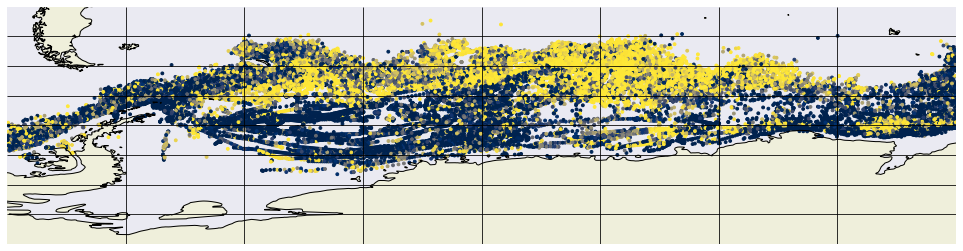

In [21]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

# random sample for plotting
rows_id = random.sample(range(0,c.size-1), random_sample_size)
lons_random_sample = lons[rows_id]
lats_random_sample = lats[rows_id]
clabels_random_sample = c[rows_id]

#colormap with Historical data
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= plt.get_cmap('cividis'),
                 s=8.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)

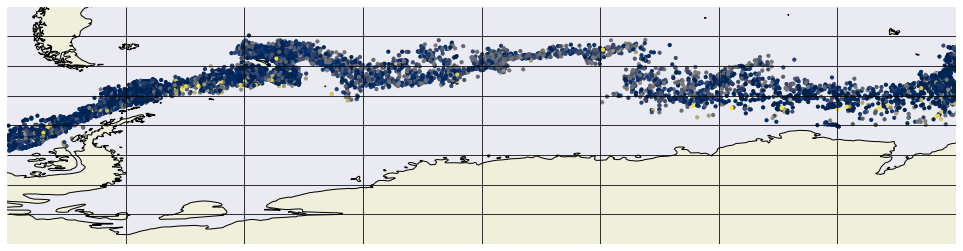

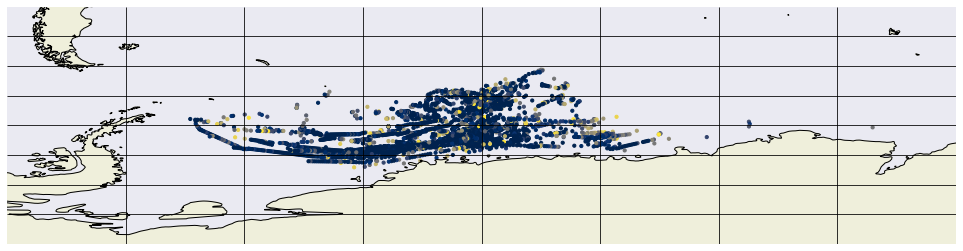

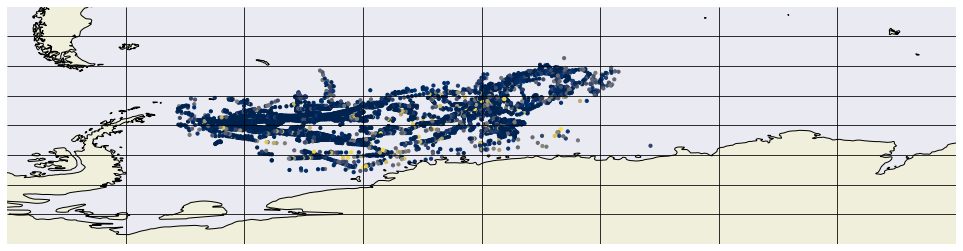

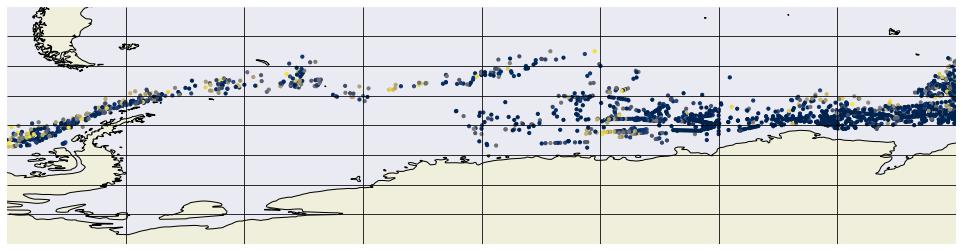

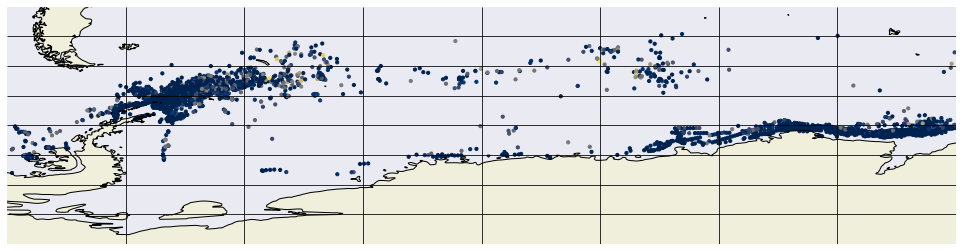

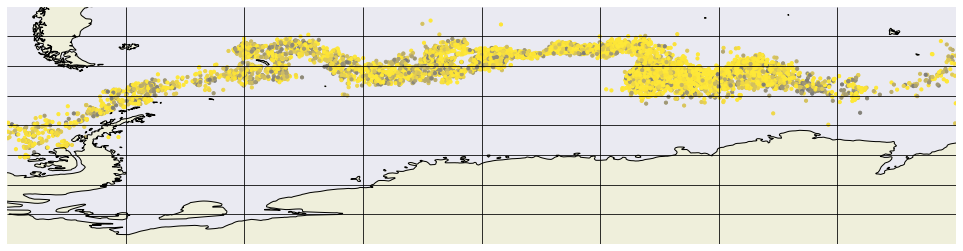

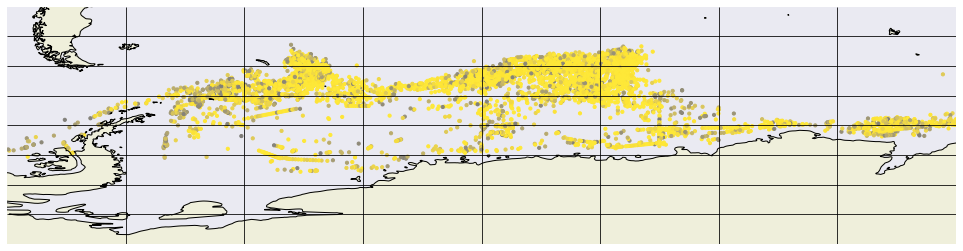

In [24]:
# extract values as new DataArrays
da_lon = df1D.lon
da_lat = df1D.lat
da_i_metric = df1D.i_metric

# extract values
lons = da_lon.values
lats = da_lat.values
c = da_i_metric.values

for iclass in range(n_components_selected):

    # random sample for plotting
    lons_random_sample = lons[labels==iclass]
    lats_random_sample = lats[labels==iclass]
    clabels_random_sample = c[labels==iclass]

    #colormap with Historical data
    plt.figure(figsize=(17, 13))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-80, 80, -85, -45], ccrs.PlateCarree())
    CS = plt.scatter(lons_random_sample-360, 
                     lats_random_sample, 
                     c=clabels_random_sample,
                     marker='o',
                     cmap= plt.get_cmap('cividis'),
                     s=10.0,
                     transform=ccrs.Geodetic(),
                     )
    ax.coastlines(resolution='50m')
    ax.gridlines(color='black')
    ax.add_feature(cartopy.feature.LAND)
    #plt.colorbar()
    plt.clim(0,1)

With K=7, we seem to have two Weddell Gyre classes, which is interesting. Kind of an east/west split, sort of. However, we also have two very ambiguous classes, as seen by the yellow shading (high i-metric values) in the bottom two plots. 

Caveats: this is sort of a climatological picture, so to speak. It will be biased towards more recent times, where the density of observations is higher. It is also biased as to where most of the observations are taken. We could try to sample more uniformly in space, although this would run the risk of having a very small sample size. 

### Separate colorbar for plotting purposes

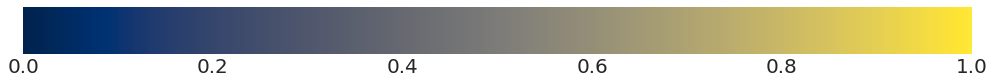

In [31]:
# colorbar all by itself
plt.figure(figsize=(17, 13))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-80, 80, -85, -45], ccrs.PlateCarree())
CS = plt.scatter(lons_random_sample-360, 
                 lats_random_sample, 
                 c=clabels_random_sample,
                 marker='o',
                 cmap= plt.get_cmap('cividis'),
                 s=10.0,
                 transform=ccrs.Geodetic(),
                 )
ax.coastlines(resolution='50m')
ax.gridlines(color='black')
ax.add_feature(cartopy.feature.LAND)
plt.gca().set_visible(False)
cbar = plt.colorbar(orientation='horizontal')
plt.clim(0,1)
cbar.ax.tick_params(labelsize=20)